In [24]:
import pandas as pd
pd.options.display.max_rows = 10
import os
import datetime
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
import pathlib
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from torchsummary import summary

def read_raw_pickle() -> dict:
    #pickle_path = os.path.dirname(os.path.realpath(__file__)) + '/validation_data.pkl'
    pickle_path = os.path.dirname(os.path.realpath("Project4")) + '/train_data.pkl'
    dict_of_df = pd.read_pickle(pickle_path)
    return dict_of_df

def get_time_code(dt):
    hour = dt.hour
    if hour < 8:
        return 0.0
    elif hour < 16:
        return 0.5
    else:
        return 1.0

def area_block(lon, lat):
    if (lon < 113.8) or (lat < 22.45) or (lon > 114.3) or (lat > 22.85): return -1
    lon_val = int((lon - 113.8)/0.1)
    lat_val = int((lat - 22.45)/0.1)
    return (lon_val + lat_val*6)/30

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def calculate_distance_and_speed(df : pd.DataFrame):
    # Calculate distance using haversine formula
    df['longitude_shift'] = df['longitude'].shift().fillna(0)
    df['latitude_shift'] = df['latitude'].shift().fillna(0)
    df['distance'] = df.apply(lambda row: haversine(row['longitude'], row['latitude'], row['longitude_shift'], row['latitude_shift']), axis=1)
    
    # Calculate speed in km/h then divide by 60 
    df['haversine_speed'] = df['distance'] / df['time_diff'] * 3600 / 60
    
    return df

def euclidean_distance(lat1, lon1, lat2, lon2):
    return ((lat2 - lat1)**2 + (lon2 - lon1)**2)**0.5

def feature_engineer(list_array : 'list[np.array]') -> 'list[pd.DataFrame]':
    list_of_columns = ['plate','longitude','latitude','second_since_midnight','status','time']
    list_of_df = []
    for plate_list in list_array:
        plate_df = pd.DataFrame(data=plate_list,columns=list_of_columns)
        
        plate_df['time'] = plate_df.apply(lambda row: datetime.strptime(row['time'], '%Y-%m-%d %H:%M:%S'), axis=1)
        # plate_df['time_interval'] = plate_df['time'].apply(lambda x: int(x.timestamp())) - plate_df['time'].shift(1).fillna(pd.Timestamp.min).apply(lambda x: int(x.timestamp()))
        plate_df['time_diff'] = plate_df['time'].diff().dt.total_seconds()
        plate_df['time_code'] = plate_df['time'].apply(lambda x: get_time_code(x))
        plate_df['is_workday'] = plate_df['time'].apply(lambda x: 1 if x.weekday() in range(0, 5) else 0)
        plate_df['area_block'] = plate_df.apply(lambda row: area_block(row['longitude'], row['latitude']),axis=1)
        
        plate_df['displacement'] = euclidean_distance(plate_df['latitude'], plate_df['longitude'],
                                     plate_df.shift(1)['latitude'], plate_df.shift(1)['longitude']).fillna(0)

        plate_df['speed'] = plate_df['displacement'] / (plate_df['time_diff'])

        plate_df['speed'] = plate_df['speed'].replace([np.inf, -np.inf], 0)

        plate_df['speed'] = plate_df['speed'].fillna(0)

        plate_df['acceleration'] = plate_df['speed'].diff() / (plate_df['time_diff'])


        plate_df['acceleration'] = plate_df['acceleration'].replace([np.inf, -np.inf], 0)

        plate_df['acceleration'] = plate_df['acceleration'].fillna(0)
        
        plate_df['day'] = plate_df['time'].dt.day
        plate_df["time_in_hour"] = plate_df["time"].dt.hour
        plate_df["time_in_minute"] = plate_df["time"].dt.minute
        plate_df["time_in_seconds"] = plate_df["time"].dt.second
        
        plate_df = calculate_distance_and_speed(plate_df)
        plate_df = plate_df.tail(-1)
        
        scaler = StandardScaler()
        
        plate_df = plate_df.replace([np.inf, -np.inf], 0)
        plate_df = plate_df.dropna()
        
        #plate_df = plate_df.drop('plate',axis=1)
        
        # Extract numerical columns
        numerical_columns = plate_df.select_dtypes(include=[np.number]).columns

        # Fit and transform scaler to numerical columns
        #plate_df[numerical_columns] = scaler.fit_transform(plate_df[numerical_columns])

        list_of_df.append(plate_df)

    return list_of_df

def slice_dataframe(list_of_df, sequence_length = 100):
    days_of_traj = []
    max_length = 512  # set the maximum sequence length to 512
    for plate_df in list_of_df:
        result = []
        values = plate_df[['distance','haversine_speed', 'status', 'time_code','is_workday','area_block', \
                          'time_diff', 'displacement', 'speed', 'acceleration', 'longitude', 'latitude', \
                          'time_in_hour', 'time_in_minute', 'time_in_seconds']].values.tolist()
        
        # Processing to ensure each sublist has a length of 100
        while len(values) > 0:
            if len(values) >= sequence_length:
                days_of_traj.append(values[:sequence_length])
                values = values[sequence_length:]
            else:
                padding = [[-1.0]*len(values[0])] * (sequence_length - len(values))
                days_of_traj.append(values + padding)
                break

    return days_of_traj





In [2]:
    
dict_of_df = read_raw_pickle()
all_trajectories = {}
pickle_dir = os.path.dirname(os.path.realpath("Project4"))
for i in tqdm(dict_of_df.keys()):  # Loop over actual keys # keys are 400 drivers preprocess loop over each driver
    cur_list_of_traj = dict_of_df[i] # cur_list_of_traj length is 5 (5 days data)
    # The rest of your processing...

    try:
        engineered_traj = feature_engineer(cur_list_of_traj)
        # Specify the desired sequence length here
        sliced_traj = slice_dataframe(engineered_traj, sequence_length=100) # 3D dimension data: N * 100 * feature dimension
        all_trajectories[i] = sliced_traj
    except Exception as e:
        print(f"Error processing trajectory {i}: {e}")
        continue

# Save the dictionary of all processed trajectories to a single pickle file
# pickle_file_path = os.path.join(pickle_dir, 'validation20_feature_all.pkl')
pickle_file_path = os.path.join(pickle_dir, 'train400_feature_all.pkl')
with open(pickle_file_path, 'wb') as f:
    pickle.dump(all_trajectories, f) 
        


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [06:14<00:00,  1.07it/s]


In [3]:
len(all_trajectories[0][0][0])

15

In [4]:
import os
import pickle
import numpy as np
from tqdm import tqdm

def read_pkl():
    pickle_path = os.path.dirname(os.path.realpath("Project4")) + '/train400_feature_all.pkl'
    if os.path.isfile(pickle_path):
        with open(pickle_path, 'rb') as handle:
            traj_dict = pickle.load(handle)
    else:
        raise FileNotFoundError("Pickle file not found")
    return traj_dict

def generate_pairs_and_labels(X_data, total_pairs=1000):
    half_pairs = total_pairs // 2  # Divide total_pairs to get half positive, half negative
    
    pos_pairs = []
    neg_pairs = []
    drivers = list(X_data.keys())
    
    # Generate Positive Pairs
    tqdm.write("Generating positive pairs...")
    while len(pos_pairs) < half_pairs:
        driver = np.random.choice(drivers)
        if len(X_data[driver]) < 2:  # Need at least 2 trajectories to form a pair
            continue
        days = np.random.choice(range(len(X_data[driver])), 2, replace=False)
        pos_pairs.append([X_data[driver][days[0]], X_data[driver][days[1]]])
    
    # Generate Negative Pairs
    tqdm.write("Generating negative pairs...")
    while len(neg_pairs) < half_pairs:
        driver1, driver2 = np.random.choice(drivers, 2, replace=False)
        if not X_data[driver1] or not X_data[driver2]:  # Skip if any driver has no data
            continue
        day1 = np.random.choice(range(len(X_data[driver1])))
        day2 = np.random.choice(range(len(X_data[driver2])))
        neg_pairs.append([X_data[driver1][day1], X_data[driver2][day2]]) # X_data[driver1][day1] 100 * feature_dimension list
    
    # Combine pairs and shuffle
    pairs = np.array(pos_pairs + neg_pairs)
    labels = np.array([1] * half_pairs + [0] * half_pairs)  # 1 for positive, 0 for negative
    
    return pairs, labels

def save_pairs_and_labels(pairs, labels, filename='X_Y_train400_pairs.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump({'pairs': pairs, 'labels': labels}, f)
    print(f"Saved pairs and labels to {filename}")

X_data = read_pkl()
total_pairs = 20000  # Total pairs you want to generate
pairs, labels = generate_pairs_and_labels(X_data, total_pairs)

# Ensure the shape is as expected
print(f"Generated pairs shape: {pairs.shape}")
print(f"Generated labels shape: {labels.shape}")

save_pairs_and_labels(pairs, labels)

Generating positive pairs...
Generating negative pairs...
Generated pairs shape: (20000, 2, 100, 15)
Generated labels shape: (20000,)
Saved pairs and labels to X_Y_train400_pairs.pkl


In [15]:
import torch
import torch.nn as nn

class SiameseLSTM(nn.Module):
    """
    Neural network model for training Siamese Networks with LSTM layers.
    """
    def __init__(self, input_dim, hidden_dim):
        super(SiameseLSTM, self).__init__()
        
        # Define LSTM layers        
        self.input_layer = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        self.hidden1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.hidden2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        
        # Define fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        Forward pass of the Siamese LSTM model.
        """
        # The input dataset shape is (number of trajectory pairs (batch size, 2, 100, feature size), split the input into two parts
        x1, x2 = x[:, 0, :, :], x[:, 1, :, :]

        # Pass the first trajectory through LSTM
        h_t11 = torch.zeros(1, x.size(0), self.input_layer.hidden_size).to(x.device)
        c_t11 = torch.zeros(1, x.size(0), self.input_layer.hidden_size).to(x.device)
        
        h_t11, c_t11 = self.input_layer(x1, (h_t11, c_t11))
        h_t12, c_t12 = self.hidden1(h_t11)
        h_t13, c_t13 = self.hidden2(h_t12)

        out1 = h_t13[:, -1, :]  # Extract the last hidden state out1 is a (128, 64) tensor
        
        #print(h_t1.shape, out1.shape)
        
        # Reinitialize hidden and cell states for the second trajectory
        h_t21 = torch.zeros(1, x.size(0), self.input_layer.hidden_size).to(x.device)
        c_t21 = torch.zeros(1, x.size(0), self.input_layer.hidden_size).to(x.device)
    
        # Pass the second trajectory through LSTM using the same hidden states
        h_t21, c_t21 = self.input_layer(x2, (h_t21, c_t21))
        h_t22, c_t22 = self.hidden1(h_t21)
        h_t23, c_t23 = self.hidden2(h_t22)

        out2 = h_t23[:, -1, :]  # Extract the last hidden state

        # Compute absolute difference between the outputs
        abs_diff = torch.abs(out1 - out2)

        # Pass the absolute difference through the fully connected layer        
        output = torch.sigmoid(self.fc(abs_diff))

        return output


In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
#from model import SiameseLSTM
import numpy as np
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SiameseDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs  # pairs is a numpy array of shape (n_samples, 2, seq_len, features)
        self.labels = labels  # labels is a numpy array of shape (n_samples,)
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.pairs[idx]
        y = self.labels[idx]
        return torch.tensor(x.tolist(), dtype=torch.float), torch.tensor(y.tolist(), dtype=torch.float)

def load_data(filename='X_Y_train400_pairs.pkl'):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    pairs = data['pairs']
    labels = data['labels']
    return pairs, labels


def train(model, optimizer, criterion, train_loader):
    """
    Function to handle the training of the model.
    Iterates over the training dataset and updates model parameters.
    """
    model.train()  # Set the model to train mode
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), targets)  # Compute the loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        # Compute statistics
        train_loss += loss.item() * inputs.size(0)
        predicted = torch.round(outputs.squeeze())
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_acc = correct / total
    
    return train_loss, train_acc

def evaluate(model, criterion, loader):
    """
    Function to evaluate the model performance on the validation set.
    Computes loss and accuracy without updating model parameters.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in loader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs.squeeze(), targets)  # Compute the loss
            
            # Compute statistics
            test_loss += loss.item() * inputs.size(0)
            predicted = torch.round(outputs.squeeze())
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    
    test_loss /= len(loader.dataset)
    test_acc = correct / total
    
    return test_loss, test_acc

def train_model():
    """
    Main function to initiate the model training process.
    Includes loading data, setting up the model, optimizer, and criterion,
    and executing the training and validation loops.
    """
    # Load data
    pairs, labels = load_data()
    dataset = SiameseDataset(pairs, labels)
    
    # Split data into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    input_dim = len(pairs[0][0][0])
    
    # Set up model, optimizer, and criterion
    model = SiameseLSTM(input_dim=input_dim, hidden_dim=64)  # Adjust input_dim and hidden_dim as per your data
    optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
    criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
    
    # Train loop
    epochs = 10
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, criterion, train_loader)
        val_loss, val_acc = evaluate(model, criterion, val_loader)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


In [25]:
pairs, labels = load_data()

In [26]:
dataset = SiameseDataset(pairs, labels)

# Split data into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [27]:
# Set up model, optimizer, and criterion
input_dim = len(pairs[0][0][0])
model = SiameseLSTM(input_dim=input_dim, hidden_dim=64)  # Adjust input_dim and hidden_dim as per your data
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification

print(model)
print(list(model.input_layer.parameters()))

SiameseLSTM(
  (input_layer): LSTM(15, 64, batch_first=True)
  (hidden1): LSTM(64, 64, batch_first=True)
  (hidden2): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
[Parameter containing:
tensor([[ 0.0145, -0.0231, -0.0884,  ..., -0.0512, -0.0566,  0.1010],
        [-0.0418,  0.0887,  0.1011,  ..., -0.1085, -0.1086, -0.0983],
        [ 0.0894,  0.0300,  0.0519,  ..., -0.0485,  0.0909,  0.0608],
        ...,
        [ 0.1167, -0.0289,  0.0741,  ..., -0.0070,  0.1114, -0.0547],
        [ 0.0248, -0.0504, -0.0443,  ..., -0.0480,  0.0813, -0.0459],
        [-0.1003, -0.0640, -0.1177,  ..., -0.0320, -0.0464, -0.0876]],
       requires_grad=True), Parameter containing:
tensor([[-0.0690,  0.0689, -0.0591,  ...,  0.0426, -0.0744, -0.0485],
        [-0.0442,  0.1204, -0.0697,  ..., -0.0939,  0.0833,  0.0918],
        [ 0.0472, -0.0571,  0.0845,  ..., -0.0047, -0.0700,  0.0982],
        ...,
        [-0.0290,  0.0720,  0.0692,  ...,  0.0688, -0.0213,  

In [ ]:
epochs = 30

accuracy_values = []

for epoch in range(epochs):
    
    train_loss, train_acc = train(model, optimizer, criterion, train_loader)
    
    accuracy_values.append(train_acc)
    
    val_loss, val_acc = evaluate(model, criterion, val_loader)
        
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

In [111]:
# 0.005 best learning rate
#torch.save(model, './model-3layer.pt')
#torch.save(model.state_dict(), './model_weights-3layer.pt')

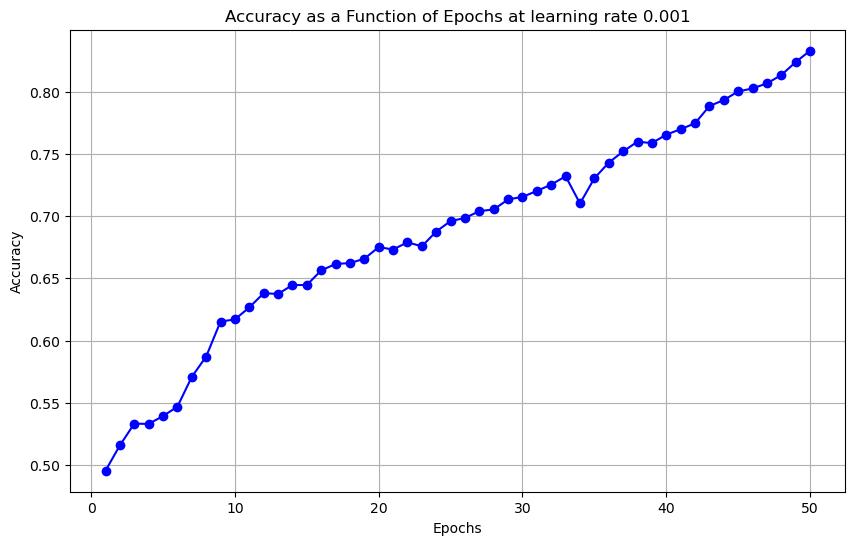

In [98]:
import matplotlib.pyplot as plt

# Plotting the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy as a Function of Epochs at learning rate 0.001')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

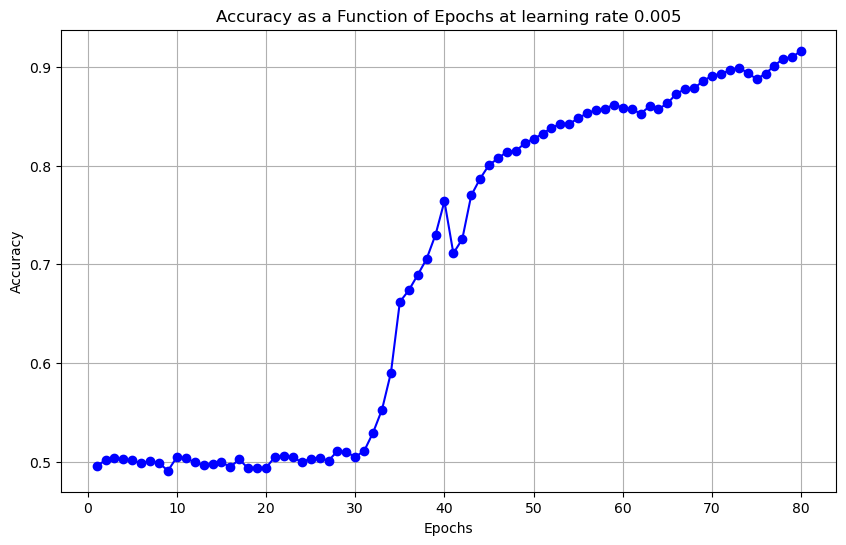

In [108]:
import matplotlib.pyplot as plt

# Plotting the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy as a Function of Epochs at learning rate 0.005')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [112]:
import torch
from torch.utils.data import DataLoader, Dataset

def test_model():
    """
    Main function to initiate the model testing process.
    Includes loading test data, setting up the model and test loader,
    and executing the testing function.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    

    # Load test data
    #test_pairs, test_labels = load_data(filename="X_Y_validation20_pairs.pkl")
    test_pairs, test_labels = load_data(filename="X_Y_train400_pairs.pkl")
    
    input_dim = len(test_pairs[0][0][0])

    # Instantiate model
    model = SiameseLSTM(input_dim, hidden_dim=64)  # Provide appropriate input_dim and hidden_dim
    model.load_state_dict(torch.load('model_weights-3layer.pt'))
    model.to(device)

    # Create DataLoader for test data
    test_dataset = SiameseDataset(test_pairs, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Testing function
    criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
    
    test_loss, test_acc = evaluate(model, criterion, test_loader)

    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")
    
test_model()

Test Loss: 0.5101636366844178, Test Accuracy: 0.82735
